In [4]:
import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile,move
import pydicom as dicom
import cv2

### Steps to generate the dataset

1. Download the datasets listed above
 * `git clone https://github.com/ieee8023/covid-chestxray-dataset.git`
 * go to this [link](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data) to download the RSNA pneumonia dataset
2. Create a `data` directory and within the data directory, create a `train` and `test` directory
3. Use [create\_COVIDx\_v2.ipynb](create_COVIDx_v2.ipynb) to combine the two dataset to create COVIDx. Make sure to remember to change the file paths.
4. We provide the train and test txt files with patientId, image path and label (normal, pneumonia or COVID-19). The description for each file is explained below:
 * [train\_COVIDx.txt](train_COVIDx.txt): This file contains the samples used for training.
 * [test\_COVIDx.txt](test_COVIDx.txt): This file contains the samples used for testing.

In [2]:
# set parameters here
savepath = '../data'
seed = 0
np.random.seed(seed) # Reset the seed so all runs are the same.
random.seed(seed)
MAXVAL = 255  # Range [0 255]

# path to covid-19 dataset from https://github.com/ieee8023/covid-chestxray-dataset
imgpath = '../data/covid-chestxray-dataset/images' 
csvpath = '../data/covid-chestxray-dataset/metadata.csv'

# path to https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
kaggle_datapath = '..data/rsna-pneumonia-detection-challenge'
kaggle_csvname = 'stage_2_detailed_class_info.csv' # get all the normal from here
kaggle_csvname2 = 'stage_2_train_labels.csv' # get all the 1s from here since 1 indicate pneumoniakaggle_imgpath = 'stage_2_train_images'

# parameters for COVIDx dataset
train = []
test = []
test_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
train_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}

#tres clases: nomal / neumonia /COVID-19
mapping = dict()
mapping['COVID-19'] = 'COVID-19'
mapping['SARS'] = 'pneumonia'
mapping['MERS'] = 'pneumonia'
mapping['Streptococcus'] = 'pneumonia'
mapping['Normal'] = 'normal'
mapping['Lung Opacity'] = 'pneumonia'
mapping['1'] = 'pneumonia'
print(mapping)
# train/test split 10% de los datos irán al test set
split = 0.1

{'COVID-19': 'COVID-19', 'SARS': 'pneumonia', 'MERS': 'pneumonia', 'Streptococcus': 'pneumonia', 'Normal': 'normal', 'Lung Opacity': 'pneumonia', '1': 'pneumonia'}


## 1) covid-chestxray-dataset
 Solo nos quedamos las imágenes de tipo Posteroanterior views (PA)

In [3]:
# adapted from https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/datasets.py#L814
#283 images
csv = pd.read_csv(csvpath, nrows=None)
images = len(csv)
idx_pa = csv["view"] == "PA"  # Keep only the PA view
csv = csv[idx_pa]
pneumonias = ["COVID-19", "SARS", "MERS", "ARDS", "Streptococcus"]
pathologies = ["Pneumonia","Viral Pneumonia", "Bacterial Pneumonia", "No Finding"] + pneumonias
pathologies = sorted(pathologies)
print(pathologies)
print('Total images {} we use {}'.format(images,len(csv)))

['ARDS', 'Bacterial Pneumonia', 'COVID-19', 'MERS', 'No Finding', 'Pneumonia', 'SARS', 'Streptococcus', 'Viral Pneumonia']
Total images 329 we use 190


In [6]:
csv2 = pd.read_csv(csvpath, nrows=None)

csv2.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


De las 300 imágenes cogemos 164 que son del tipo de vista PA (no axial, L, AP Supine, Coronal...)

A continuación seleccionaremos solamente un tipo de patologías que tenemos en la variable mapping dejando otras como Pneumocystis o Streptococcus y nos quedaremos con 132 imágenes


In [7]:
# get non-COVID19 viral, bacteria, and COVID-19 infections from covid-chestxray-dataset
# stored as patient id, image filename and label
filename_label = {'normal': [], 'pneumonia': [], 'COVID-19': []}
count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
for index, row in csv.iterrows():
    f = row['finding']
    if f in mapping:
        count[mapping[f]] += 1
        entry = [int(row['patientid']), row['filename'], mapping[f]]
        filename_label[mapping[f]].append(entry)

print('Data distribution from covid-chestxray-dataset:')
print(count)

Data distribution from covid-chestxray-dataset:
{'normal': 0, 'pneumonia': 24, 'COVID-19': 108}


Creamos nuestro dataset con una carpeta for clase. También creamos el test set que aislaremos para utilizar mas tarde
Iremos moviendo las imagenes a sus carpetas correspondientes.

In [8]:
#Create sets train/normal | train/pneumonia | train/COVID19
for key, value in filename_label.items() :
    savepathTrain = os.path.join(savepath, 'train', key)
    os.makedirs(savepathTrain, exist_ok=True)
    
for key, value in filename_label.items() :    
    savepathTest = os.path.join(savepath, 'test', key)
    print(savepathTest)
    os.makedirs(savepathTest, exist_ok=True)

/media/juanluis/data1/covid19/data/test/normal
/media/juanluis/data1/covid19/data/test/pneumonia
/media/juanluis/data1/covid19/data/test/COVID-19


In [10]:
# add covid-chestxray-dataset into COVIDx dataset
# since covid-chestxray-dataset doesn't have test dataset
# split into train/test by patientid
# for COVIDx:
# patient 8 is used as non-COVID19 viral test
# patient 31 is used as bacterial test
# patients 19, 20, 36, 42, 86 are used as COVID-19 viral test

for key in filename_label.keys():
    arr = np.array(filename_label[key])
    if arr.size == 0:
        continue
    # split by patients
    # num_diff_patients = len(np.unique(arr[:,0]))
    # num_test = max(1, round(split*num_diff_patients))
    # select num_test number of random patients
    if key == 'pneumonia':
        test_patients = ['8', '31']
    elif key == 'COVID-19':
        test_patients = ['19', '20', '36', '42', '86'] # random.sample(list(arr[:,0]), num_test)
    else: 
        test_patients = []
    print('Key: ', key)
    print('Test patients: ', test_patients)
    # go through all the patients
    # I added .replace(" ", "") because of problems in the csv
    for patient in arr:
        if patient[0] in test_patients:            
            #copyfile(os.path.join(imgpath, patient[1].replace(" ", "") ), os.path.join(savepath, 'test', patient[2], patient[1]))
            test.append(patient)
            test_count[patient[2]] += 1
        else:                        
            #copyfile(os.path.join(imgpath, patient[1].replace(" ", "")), os.path.join(savepath, 'train', patient[2], patient[1]))
            train.append(patient)
            train_count[patient[2]] += 1

print('test count: ', test_count)
print('train count: ', train_count)

Key:  pneumonia
Test patients:  ['8', '31']
Key:  COVID-19
Test patients:  ['19', '20', '36', '42', '86']
test count:  {'normal': 0, 'pneumonia': 5, 'COVID-19': 10}
train count:  {'normal': 0, 'pneumonia': 19, 'COVID-19': 98}


## 2) - rsna-pneumonia-detection-challenge dataset

Lo mismo que arriba leemos la información sobre las imágenes y nos quedamos con los pacientes clasificados Normal y Pneumonia

In [11]:
# add normal and rest of pneumonia cases from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
csv_normal = pd.read_csv(os.path.join(kaggle_datapath, kaggle_csvname), nrows=None)
csv_pneu = pd.read_csv(os.path.join(kaggle_datapath, kaggle_csvname2), nrows=None)
patients = {'normal': [], 'pneumonia': []}

for index, row in csv_normal.iterrows():
    if row['class'] == 'Normal':
        patients['normal'].append(row['patientId'])

for index, row in csv_pneu.iterrows():
    if int(row['Target']) == 1:
        patients['pneumonia'].append(row['patientId'])
kaggle_imgpath = 'stage_2_train_images'
for key in patients.keys():
    arr = np.array(patients[key])
    print('Copying {} patients with diagnosis as {}'.format(arr.size,key))
    if arr.size == 0:
        continue
    # split by patients 
    # num_diff_patients = len(np.unique(arr))
    # num_test = max(1, round(split*num_diff_patients))
    test_patients = np.load('rsna_test_patients_{}.npy'.format(key)) # random.sample(list(arr), num_test), download the .npy files from the repo.
    # np.save('rsna_test_patients_{}.npy'.format(key), np.array(test_patients))
    for patient in arr:        
        ds = dicom.dcmread(os.path.join(kaggle_datapath, kaggle_imgpath, patient + '.dcm'))
        pixel_array_numpy = ds.pixel_array
        imgname = patient + '.png'
        if patient in test_patients:
            #cv2.imwrite(os.path.join(savepath, 'test', key, imgname), pixel_array_numpy)            
            test.append([patient, imgname, key])
            test_count[key] += 1
        else:
            #cv2.imwrite(os.path.join(savepath, 'train', key, imgname), pixel_array_numpy)            
            train.append([patient, imgname, key])
            train_count[key] += 1

print('test count: ', test_count)
print('train count: ', train_count)

Copying 8851 patients with diagnosis as normal
Copying 9555 patients with diagnosis as pneumonia
test count:  {'normal': 885, 'pneumonia': 1058, 'COVID-19': 10}
train count:  {'normal': 7966, 'pneumonia': 8521, 'COVID-19': 98}


Final stats
Train count:  {'normal': 7966, 'pneumonia': 8521, 'COVID-19': 98}
Test count:  {'normal': 885, 'pneumonia': 1058, 'COVID-19': 10}
Total length of train:  16585
Total length of test:  1953


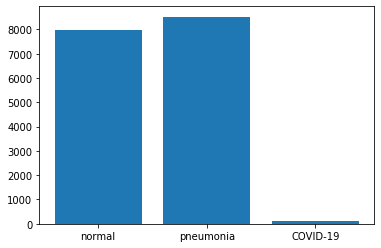

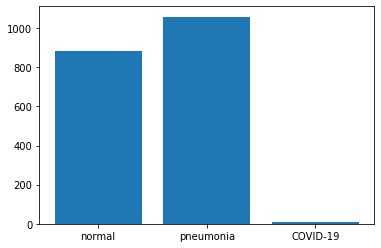

In [12]:
# final stats
import matplotlib.pyplot as plt

print('Final stats')
print('Train count: ', train_count)
print('Test count: ', test_count)
print('Total length of train: ', len(train))
print('Total length of test: ', len(test))

plt.bar(range(len(train_count)), list(train_count.values()), align='center')
plt.xticks(range(len(train_count)), list(train_count.keys()))
plt.show()

plt.bar(range(len(test_count)), list(test_count.values()), align='center')
plt.xticks(range(len(test_count)), list(test_count.keys()))
plt.show()

In [9]:
from os import listdir
from os.path import isfile, join
from PIL import Image


def print_data(data):
    """
    Parameters
    ----------
    data : dict
    """
#    for k, v in data.items():
#        print("%s:\t%s" % (k, v))
    print("Min width: %i" % data['min_width']," Max width: %i" % data['max_width'])  
    print("Min height: %i" % data['min_height']," Max height: %i" % data['max_height'])

def main(path):
    """
    Parameters
    ----------
    path : str
        Path where to look for image files.
    """
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    # Filter files by extension
    #onlyfiles = [f for f in onlyfiles if f.endswith('.jpg')]

    data = {}
    data['images_count'] = len(onlyfiles)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0

    for filename in onlyfiles:
        im = Image.open(join(path,filename))
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    print_data(data)
print('Pneumonia')
main('../data/train/pneumonia')
print('Normal')
main('../data/train/normal')
print('Covid-19')
main('../data/train/COVID-19')


Pneumonia
Min width: 1024  Max width: 3000
Min height: 1022  Max height: 3056
Normal
Min width: 1024  Max width: 1024
Min height: 1024  Max height: 1024
Covid-19
Min width: 255  Max width: 4280
Min height: 237  Max height: 4095
